# VO2max Prediction Using Treadmill Maximal Exercise Tests and Machine Learning Techniques

In [2]:
# import packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import signal
from collections import Counter
from sklearn.utils import indexable
from sklearn.utils import resample
from sklearn.utils.validation import _num_samples
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from itertools import chain
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, MultiTaskLassoCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import ceil, floor

In [3]:
# load subject dataset
subject_data = pd.read_csv('physionet.org/files/treadmill-exercise-cardioresp/1.0.1/subject-info.csv')

# basic information
display(subject_data.head())
print("Initial Dataset Info:")
print(subject_data.info())
print(subject_data.describe())

,Age,Weight,Height,Humidity,Temperature,Sex,ID,ID_test
0,10.8,48.8,163.0,39.0,20.7,1,543,543_1
1,11.8,41.0,150.0,41.0,22.3,1,11,11_1
2,12.2,46.0,160.0,37.0,21.5,0,829,829_1
3,13.2,71.0,190.0,49.0,23.8,1,284,284_1
4,13.7,53.8,169.7,40.0,25.3,0,341,341_1


Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          992 non-null    float64
 1   Weight       992 non-null    float64
 2   Height       992 non-null    float64
 3   Humidity     962 non-null    float64
 4   Temperature  962 non-null    float64
 5   Sex          992 non-null    int64  
 6   ID           992 non-null    int64  
 7   ID_test      992 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 62.1+ KB
None
              Age      Weight      Height    Humidity  Temperature  \
count  992.000000  992.000000  992.000000  962.000000   962.000000   
mean    28.979133   73.383367  174.913508   48.211435    22.818565   
std     10.076653   12.005361    7.950027    8.560991     2.784066   
min     10.800000   41.000000  150.000000   23.700000    15.000000   
25%     21.100000   66.000000  170.0

In [4]:
# load measurement dataset
measurement_data = pd.read_csv('physionet.org/files/treadmill-exercise-cardioresp/1.0.1/test_measure.csv')

# basic information
measurement_data

,time,Speed,HR,VO2,VCO2,RR,VE,ID_test,ID
0,0,5.0,63.0,478.0,360.0,27,13.3,2_1,2
1,2,5.0,75.0,401.0,295.0,23,10.3,2_1,2
2,4,5.0,82.0,449.0,319.0,29,12.2,2_1,2
3,7,5.0,87.0,461.0,340.0,28,12.8,2_1,2
4,9,5.0,92.0,574.0,417.0,28,14.6,2_1,2
...,...,...,...,...,...,...,...,...,...
575082,926,5.0,148.0,1350.0,1699.0,35,65.7,857_1,857
575083,927,5.0,147.0,1275.0,1605.0,32,60.1,857_1,857
575084,929,5.0,147.0,1259.0,1566.0,29,57.0,857_1,857
575085,931,5.0,147.0,1278.0,1587.0,31,58.5,857_1,857


In [5]:
# merge both datasets on ID
#merged_data = pd.merge(measurement_data, subject_data, on='ID', how='inner')
merged_data = measurement_data
merged_data

,time,Speed,HR,VO2,VCO2,RR,VE,ID_test,ID
0,0,5.0,63.0,478.0,360.0,27,13.3,2_1,2
1,2,5.0,75.0,401.0,295.0,23,10.3,2_1,2
2,4,5.0,82.0,449.0,319.0,29,12.2,2_1,2
3,7,5.0,87.0,461.0,340.0,28,12.8,2_1,2
4,9,5.0,92.0,574.0,417.0,28,14.6,2_1,2
...,...,...,...,...,...,...,...,...,...
575082,926,5.0,148.0,1350.0,1699.0,35,65.7,857_1,857
575083,927,5.0,147.0,1275.0,1605.0,32,60.1,857_1,857
575084,929,5.0,147.0,1259.0,1566.0,29,57.0,857_1,857
575085,931,5.0,147.0,1278.0,1587.0,31,58.5,857_1,857


## Feature Selection

The feature selection process is based on the Paper: ... .

### Data Cleaning and Pre-processing

In [6]:
# check if there are missing values
print(merged_data.isnull().sum())

time          0
Speed         0
HR          981
VO2        4871
VCO2       4871
RR            0
VE            0
ID_test       0
ID            0
dtype: int64


In [7]:
# remove rows with missing target variable (HR, VO2)
merged_data_cleaned = merged_data.dropna(subset=['HR', 'VO2'])

# Check how many rows are removed
print(f'Rows removed due to missing HR or VO2: {len(merged_data) - len(merged_data_cleaned)}')

Rows removed due to missing HR or VO2: 5840


In [8]:
# if all data from one specific test_ID has to be removed where missing values of HR or VO2 are present
difference = pd.merge(merged_data, merged_data_cleaned, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
exclude_ids = difference['ID_test'].unique()

merged_data_cleaned = merged_data_cleaned[~merged_data_cleaned['ID_test'].isin(exclude_ids)]

In [9]:
print("Exercise Data RR Intervals:")
merged_data_cleaned['RR']

Exercise Data RR Intervals:


602       30
603       29
604       29
605       32
606       34
          ..
575082    35
575083    32
575084    29
575085    31
575086    31
Name: RR, Length: 381609, dtype: int64

In [10]:
# remove RR intervals exclusive to the range 300-2000 ms
# those are considered as outliers
# Entferne RR-Werte, die außerhalb des Bereichs von 5-50 Atemzügen pro Minute liegen (Ausreißer)
merged_data_cleaned['RR'] = np.where((merged_data_cleaned['RR'] < 5) | (merged_data_cleaned['RR'] > 50), np.nan, merged_data_cleaned['RR'])

# linear interpolation to fill missing values
merged_data_cleaned['RR'] = merged_data_cleaned['RR'].interpolate(method='linear')

# Check for NaN values after interpolation
merged_data_cleaned.isnull().sum()

time       0
Speed      0
HR         0
VO2        0
VCO2       0
RR         0
VE         0
ID_test    0
ID         0
dtype: int64

In [11]:
# remove data points where HR and VO2 are out of ohase
delta_hr = np.diff(merged_data_cleaned['HR'])
delta_vo2max = np.diff(merged_data_cleaned['VO2'])

merged_data_cleaned = merged_data_cleaned.iloc[:-1]  # Drop the last row
in_phase_mask = (delta_hr * delta_vo2max) > 0  # Create a mask for in-phase points
merged_data_cleaned = merged_data_cleaned[in_phase_mask]


In [12]:
#  remove where consecutive HR differs more by than 30 bpm_
merged_data_cleaned['HR_diff'] = merged_data_cleaned['HR'].diff().abs()
merged_data_cleaned = merged_data_cleaned[merged_data_cleaned['HR_diff'] <= 30]

# remove objects with less than 5 minutes of data
merged_data_cleaned['time'] = merged_data_cleaned['time'].astype(float)  # make it numeirc
merged_data_cleaned = merged_data_cleaned[merged_data_cleaned['time'] >= 300]

# check dataset
print(f'Dataset size after cleaning: {merged_data_cleaned.shape}')

Dataset size after cleaning: (66300, 10)


In [13]:
# split data into exercise and recovery phases
exercise_data = merged_data_cleaned[merged_data_cleaned['Speed'] >= 5]  # Exercise phase
recovery_data = merged_data_cleaned[merged_data_cleaned['Speed'] < 5]  # Recovery phase

# shapes of dataframes
print(f'Exercise data size: {exercise_data.shape}')
print(f'Recovery data size: {recovery_data.shape}')

Exercise data size: (58349, 10)
Recovery data size: (7951, 10)


## Feature Extraction

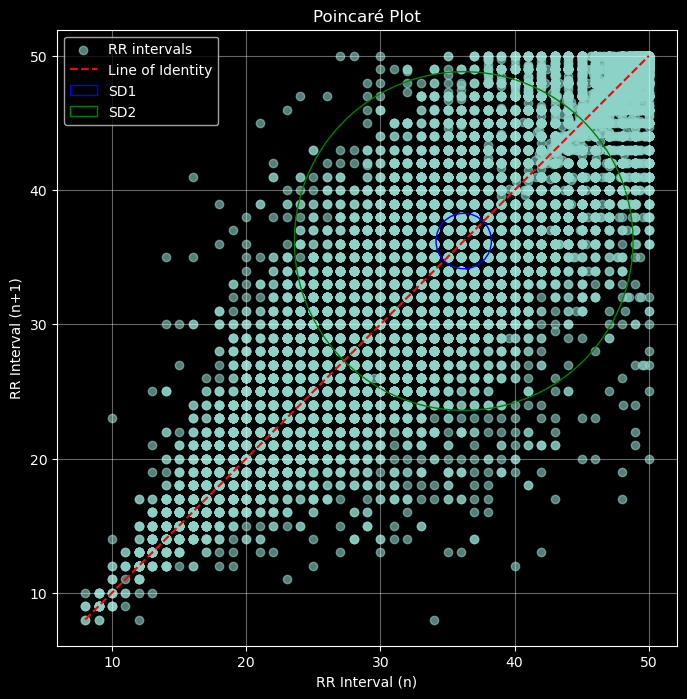

SD1: 2.06 ms
SD2: 12.62 ms


In [14]:
# Sample RR intervals (replace with your own data)
rr_intervals = merged_data_cleaned['RR'].values
# Calculate consecutive differences
rr_diff1 = rr_intervals[:-1]
rr_diff2 = rr_intervals[1:]

# Calculate mean of RR intervals
rr_mean = np.mean(rr_intervals)

# Calculate SD1 and SD2
sd1 = np.sqrt(0.5) * np.std(rr_diff2 - rr_diff1)
sd2 = np.sqrt(2 * np.std(rr_diff1)**2 - sd1**2)

# Line of identity
identity_line = np.linspace(min(rr_intervals), max(rr_intervals), 100)

# Create Poincaré plot
plt.figure(figsize=(8, 8))
plt.scatter(rr_diff1, rr_diff2, alpha=0.6, label="RR intervals")
plt.plot(identity_line, identity_line, color="red", linestyle="--", label="Line of Identity")
plt.xlim(min(rr_intervals), max(rr_intervals)+20)
plt.ylim(min(rr_intervals), max(rr_intervals)+20)
# SD1 and SD2 ellipse visualization
mean_rr = [np.mean(rr_diff1), np.mean(rr_diff2)]
ellipse_angle = 45
ellipse_sd1 = plt.Circle(mean_rr, sd1, color="blue", fill=False, label="SD1")
ellipse_sd2 = plt.Circle(mean_rr, sd2, color="green", fill=False, label="SD2")
plt.gca().add_patch(ellipse_sd1)
plt.gca().add_patch(ellipse_sd2)

# Formatting
plt.title("Poincaré Plot")
plt.xlabel("RR Interval (n)")
plt.ylabel("RR Interval (n+1)")
plt.legend()
plt.grid(alpha=0.4)
plt.axis("equal")
plt.show()

# Print SD1 and SD2
print(f"SD1: {sd1:.2f} ms")
print(f"SD2: {sd2:.2f} ms")


In [15]:
# auch mit chat GPT lol
from scipy.signal import welch
from scipy.stats import linregress, shapiro

def calculate_slopes(df, feature):
    if len(df) == 0:
        return np.nan
    else:
        slope = linregress(df['time'], df[feature]).slope
        return slope

# all HR Features

def compute_hr_features(segment: pd.DataFrame) -> dict:

    hr = segment['HR'].values
    time = segment['time'].values
    rr_intervals = segment['RR'].values 

    # Zeit-Domain-Features
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))  # Berechnung von RMSSD
    pnn20 = np.mean(np.abs(np.diff(rr_intervals)) > 0.5) * 100  # Prozentsatz der Differenzen > 20 ms ~ 0.5 respiration/min
    pnn50 = np.mean(np.abs(np.diff(rr_intervals)) > 1.25) * 100  # Prozentsatz der Differenzen > 50 ms
    nni20 = np.sum(np.abs(np.diff(rr_intervals)) > 0.5)      # Anzahl der Differenzen > 20 ms
    nni50 = np.sum(np.abs(np.diff(rr_intervals)) > 1.25)      # Anzahl der Differenzen > 50 ms
    nni_range = np.max(rr_intervals) - np.min(rr_intervals)  # Bereich zwischen max. und min. RR-Intervall
    
    # Frequenz-Domain-Features
    
    # total_power = np.var(detrend(rr_intervals))  # Gesamtvarianz nach Detrend
    # vlf_power = total_power * 0.1  # Dummy-Verhältnis für VLF-Power (simuliert)
    # lf_power = total_power * 0.3  # Dummy-Verhältnis für LF-Power (simuliert)
    # hf_power = total_power * 0.6  # Dummy-Verhältnis für HF-Power (simuliert)
    
    fs = 4  # Annahme: Sampling-Frequenz von 4 Hz
    f, pxx = welch(rr_intervals, fs, nperseg=len(rr_intervals))
    vlf_power = np.trapz(pxx[(f >= 0.003) & (f < 0.04)], f[(f >= 0.003) & (f < 0.04)])
    lf_power = np.trapz(pxx[(f >= 0.04) & (f < 0.15)], f[(f >= 0.04) & (f < 0.15)])
    hf_power = np.trapz(pxx[(f >= 0.15) & (f < 0.4)], f[(f >= 0.15) & (f < 0.4)])
    lf_nu_power = lf_power / (vlf_power + lf_power + hf_power)

    # Nichtlineare Merkmale (Poincare Plot, DFA)
    sd1 = np.sqrt(0.5) * np.std(rr_diff2 - rr_diff1)
    sd2 = np.sqrt(2 * np.std(rr_diff1)**2 - sd1**2)
    
    # sd1 = np.std(rr_intervals[:len(rr_intervals)//2])  # Kurzfristige Variation (SD1)
    # sd2 = np.std(rr_intervals[len(rr_intervals)//2:])  # Langfristige Variation (SD2)

    # sd1 = np.std(hr[:len(hr)//2])
    # sd2 = np.std(hr[len(hr)//2:])
    
    # DFA (Detrended Fluctuation Analysis) als Platzhalter (echte Implementierung erfordert spezialisierte Bibliotheken)
    # Dummy-Wert für DFA a1 (z.B. von einer DFA-Analyse)
    #dfa_a1 = 0.75  # Beispielwert für DFA a1
    dfa_a1 = np.std(rr_intervals[:len(rr_intervals)//2]) / np.std(rr_intervals) # placeholder
    

    # Berechnung der Steigungen der Merkmale über die Zeit
    # Beispiel: Steigung des HRs über Zeit
    slope_nni = np.polyfit(time, hr, 1)[0]
    
    # # Steigungen für Poincare Plot-Merkmale
    # slope_sd1 = np.polyfit(time, [sd1] * len(time), 1)[0]
    # slope_sd2 = np.polyfit(time, [sd2] * len(time), 1)[0]

    # Zeitbasierte Merkmale (Beispiel)
    max_speed = segment['Speed'].max()
    max_hr = max(segment['HR'])
    min_hr = min(segment['HR'])
    slope_sp25 = calculate_slopes(segment[segment['Speed'] <= max_speed * 0.25], 'HR')
    slope_sp50 = calculate_slopes(segment[(segment['Speed'] <= max_speed * 0.5) & (segment['Speed'] > max_speed * 0.25)], 'HR')
    slope_sp75 = calculate_slopes(segment[(segment['Speed'] <= max_speed * 0.75) & (segment['Speed'] > max_speed * 0.5)], 'HR')
    slope_sp100 = calculate_slopes(segment[(segment['Speed'] > max_speed * 0.75)], 'HR')
    rt25 = segment.loc[segment['time'] <= segment['time'].max() * 0.25, 'HR'].corr(segment['time'])
    rt50 = segment.loc[(segment['time'] >= segment['time'].max() * 0.25) & (segment['time'] < segment['time'].max() * 0.5), 'HR'].corr(segment['time'])
    rt75 = segment.loc[(segment['time'] >= segment['time'].max() * 0.5) & (segment['time'] < segment['time'].max() * 0.75), 'HR'].corr(segment['time'])
    rsp75 = segment.loc[segment['Speed'] <= max_speed * 0.75, 'HR'].corr(segment['Speed'])
    rsp25 = segment.loc[segment['Speed'] <= max_speed * 0.25, 'HR'].corr(segment['Speed'])
    time_sp25 = segment[segment['Speed'] >= max_speed * 0.25]['time'].min()
    time_hr25 = segment[segment['HR'] >= max_hr * 0.25]['time'].min()
    time_hr50 = segment[segment['HR'] >= max_hr * 0.5]['time'].min()
    time_hr75 = segment[segment['HR'] >= max_hr * 0.75]['time'].min()
    duration_hr60 = len(segment[(segment['HR'] >= max_hr * 0.5) & (segment['HR'] < max_hr * 0.6)]) * (segment['time'].diff().mean())
    duration_hr70 = len(segment[(segment['HR'] >= max_hr * 0.6) & (segment['HR'] < max_hr * 0.7)]) * (segment['time'].diff().mean())
    duration_hr80 = len(segment[(segment['HR'] >= max_hr * 0.7) & (segment['HR'] < max_hr * 0.8)]) * (segment['time'].diff().mean())
    duration_hr90 = len(segment[(segment['HR'] >= max_hr * 0.8) & (segment['HR'] < max_hr * 0.9)]) * (segment['time'].diff().mean())
    duration_hr100 = len(segment[(segment['HR'] >= max_hr * 0.9) & (segment['HR'] <= max_hr)]) * (segment['time'].diff().mean())

    
    # Feature Dictionary
    Features = {'RMSSD': rmssd,
        'PNN20': pnn20,
        'PNN50': pnn50,
        'NNI20': nni20,
        'NNI50': nni50,
        'NNI_Range': nni_range,
        'VLF_Power': vlf_power,
        'LF_Power': lf_power,
        'HF_Power': hf_power,
        'LF_Nu_Power': lf_nu_power,
        'SD1': sd1,
        'SD2': sd2,
        'DFA_A1': dfa_a1,
        'Slope_NNI': slope_nni,
        'Slope_Speed25': slope_sp25,
        'Slope_Speed50': slope_sp50,
        'Slope_Speed75': slope_sp75,
        'Slope_Speed100': slope_sp100,
        'RT25': rt25,
        'RT50': rt50,
        'RT75': rt75,
        'RSP75': rsp75,
        'RSP25': rsp25,
        'Time_SP25': time_sp25,
        'Time_HR25': time_hr25,
        'Time_HR50': time_hr50,
        'Time_HR75': time_hr75,
        'DurationHR60': duration_hr60,
        'DurationHR70': duration_hr70,
        'DurationHR80': duration_hr80,
        'DurationHR90': duration_hr90,
        'DurationHR100': duration_hr100
    }
    
    return Features
    



In [31]:
def calculate_features_per_segment(df, test_column):
    """
    Berechnet Features für jedes Segment basierend auf der test_ID.
    
    Parameters:
    df (pd.DataFrame): Der DataFrame, der die Daten enthält.
    test_column (str): Der Name der Spalte, die die Test-IDs enthält.
    
    Returns:
    pd.DataFrame: Ein DataFrame mit den berechneten Features für jedes Segment.
    """
    # Leere Liste für die Features pro Segment
    all_features = []

    # Gehe durch jede Gruppe (Segment) basierend auf der test_ID
    for test_id, df_segment in df.groupby(test_column):
        # Berechne die Features für das aktuelle Segment
        features = compute_hr_features(df_segment)
        # Füge die Test-ID zu den Features hinzu
        features[test_column] = test_id
        # Hänge die Features für dieses Segment an die Liste an
        all_features.append(features)

    # Erstelle einen DataFrame aus der Liste der Features
    df_features = pd.DataFrame(all_features)
    return df_features

In [17]:
# just for testing the feature calculat
# for test_id, df_segment in merged_data_cleaned.groupby('ID_test'):
#     #print(test_id)
#     if test_id == '3_1':
#         test_segment = merged_data_cleaned[merged_data_cleaned['ID_test'] == test_id]
#         break
# compute_hr_features(test_segment)

In [32]:
additional_features_exercise = calculate_features_per_segment(exercise_data, 'ID_test')#ID_test_y')
additional_features_recovery = calculate_features_per_segment(recovery_data, 'ID_test')#ID_test_y')
#new_features['ID_test'] = new_features['ID_test_y']
merged_data_exercise = pd.merge(subject_data, additional_features_exercise, on='ID_test', how='inner')
merged_data_recovery = pd.merge(subject_data, additional_features_recovery, on='ID_test', how='inner')

c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\

In [33]:
# normalize features
def normalize_features(dataframe):
    # Prüfen, welche Spalten numerisch sind (außer Zielvariablen oder IDs)
    numerical_features = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # StandardScaler für Normalisierung (mean=0, std=1)
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(dataframe[numerical_features])

    # In DataFrame umwandeln für Klarheit
    normalized_df = pd.DataFrame(normalized_data, columns=numerical_features)

    # Originale DataFrame kopieren und normalisierte Werte einfügen
    normalized_features = dataframe.copy()
    normalized_features[numerical_features] = normalized_df

    return normalized_features

normalized_features_exercise = normalize_features(merged_data_exercise)
normalized_features_recovery = normalize_features(merged_data_recovery)



c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample

In [36]:
def shapiro_wilk_test(dataframe):
    # Prüfen, welche Spalten numerisch sind (außer Zielvariablen oder IDs)
    numerical_features = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Shapiro-Wilk-Test für jede numerische Spalte
    shapiro_results = {}
    for column in numerical_features:
        stat, p = shapiro(dataframe[column])
        shapiro_results[column] = {'Statistic': stat, 'p-value': p}

    # Ergebnisse in DataFrame umwandeln
    shapiro_results_df = pd.DataFrame(shapiro_results).T
    shapiro_results_df.columns = ['Shapiro Statistic', 'p-value']
    
    # Identifizieren von Spalten, die nicht normalverteilt sind
    non_normal_features = shapiro_results_df[shapiro_results_df['p-value'] <= 0.05]

    return shapiro_results_df, non_normal_features


# Ergebnisse anzeigen
print("Shapiro-Wilk-Test Ergebnisse Exercise Data:")
shapiro_results_exercise, non_normal_features_exercise = shapiro_wilk_test(normalized_features_exercise)
#print(shapiro_results_exercise)
print("Shapiro-Wilk-Test Ergebnisse Recovery Data:")
shapiro_results_recovery, non_normal_features_recovery = shapiro_wilk_test(normalized_features_recovery)
#print(shapiro_results_recovery)

print("\nExercise Features, die NICHT normalverteilt sind:")
print(non_normal_features_exercise)
print("\nRecovery Features, die NICHT normalverteilt sind:")
print(non_normal_features_recovery)


Shapiro-Wilk-Test Ergebnisse Exercise Data:
Shapiro-Wilk-Test Ergebnisse Recovery Data:

Exercise Features, die NICHT normalverteilt sind:
                Shapiro Statistic       p-value
Age                      0.944843  6.085348e-15
Weight                   0.979253  4.776733e-08
Sex                      0.424351  2.271237e-41
ID                       0.963821  1.130394e-11
RMSSD                    0.961890  4.724737e-12
PNN20                    0.964520  1.561634e-11
PNN50                    0.994788  2.422459e-02
NNI_Range                0.989046  7.817591e-05
LF_Power                 0.810771  4.373843e-27
HF_Power                 0.740825  8.370208e-31
DFA_A1                   0.957902  8.520009e-13
Slope_NNI                0.926532  2.018581e-17
Slope_Speed100           0.897118  1.338139e-20
RT75                     0.577465  4.404959e-37
Time_SP25                0.376181  1.591927e-42
Time_HR25                0.376181  1.591927e-42
Time_HR50                0.387675  2.954781e-

c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


### Feature Correlation

In [37]:
normalized_features_exercise.columns

Index(['Age', 'Weight', 'Height', 'Humidity', 'Temperature', 'Sex', 'ID',
       'ID_test', 'RMSSD', 'PNN20', 'PNN50', 'NNI20', 'NNI50', 'NNI_Range',
       'VLF_Power', 'LF_Power', 'HF_Power', 'LF_Nu_Power', 'SD1', 'SD2',
       'DFA_A1', 'Slope_NNI', 'Slope_Speed25', 'Slope_Speed50',
       'Slope_Speed75', 'Slope_Speed100', 'RT25', 'RT50', 'RT75', 'RSP75',
       'RSP25', 'Time_SP25', 'Time_HR25', 'Time_HR50', 'Time_HR75',
       'DurationHR60', 'DurationHR70', 'DurationHR80', 'DurationHR90',
       'DurationHR100'],
      dtype='object')

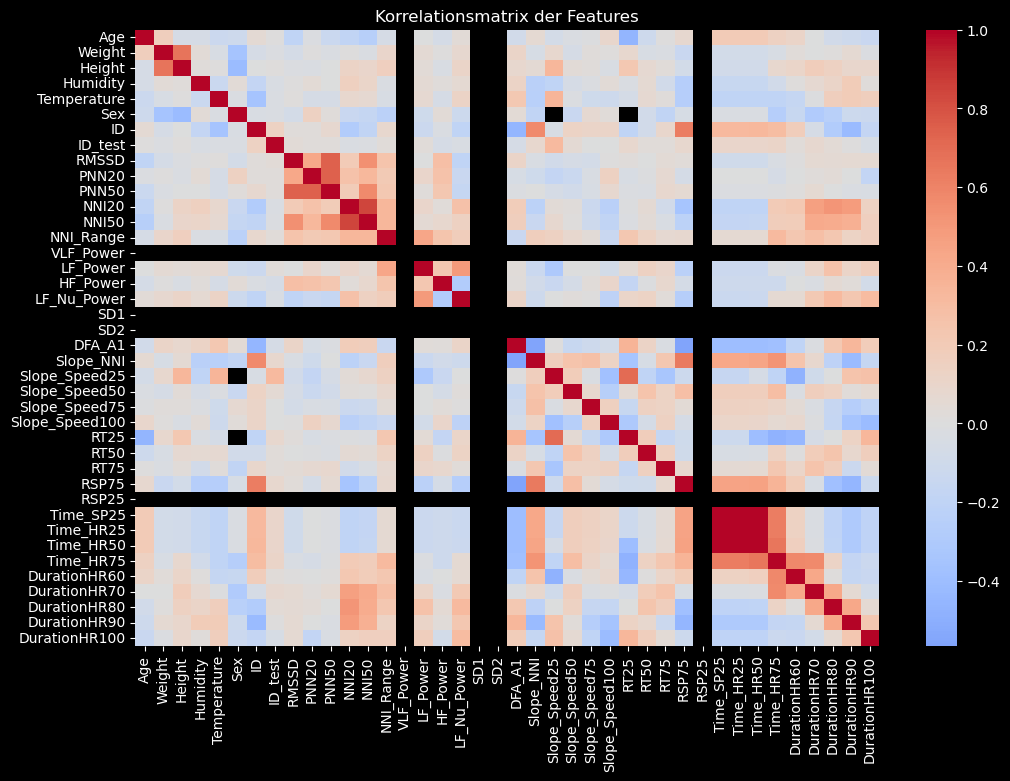


Stark korrelierte Feature-Paare:
      RMSSD     PNN20     PNN50               NNI20     NNI50 Slope_Speed25  \
      PNN50     PNN50     RMSSD     PNN20     NNI50     NNI20          RT25   
0  0.738346  0.739347  0.738346  0.739347  0.844753  0.844753      0.705314   

           RT25 Time_SP25           Time_HR25           Time_HR50            
  Slope_Speed25 Time_HR25 Time_HR50 Time_SP25 Time_HR50 Time_SP25 Time_HR25  
0      0.705314       1.0  0.994603       1.0  0.994603  0.994603  0.994603  


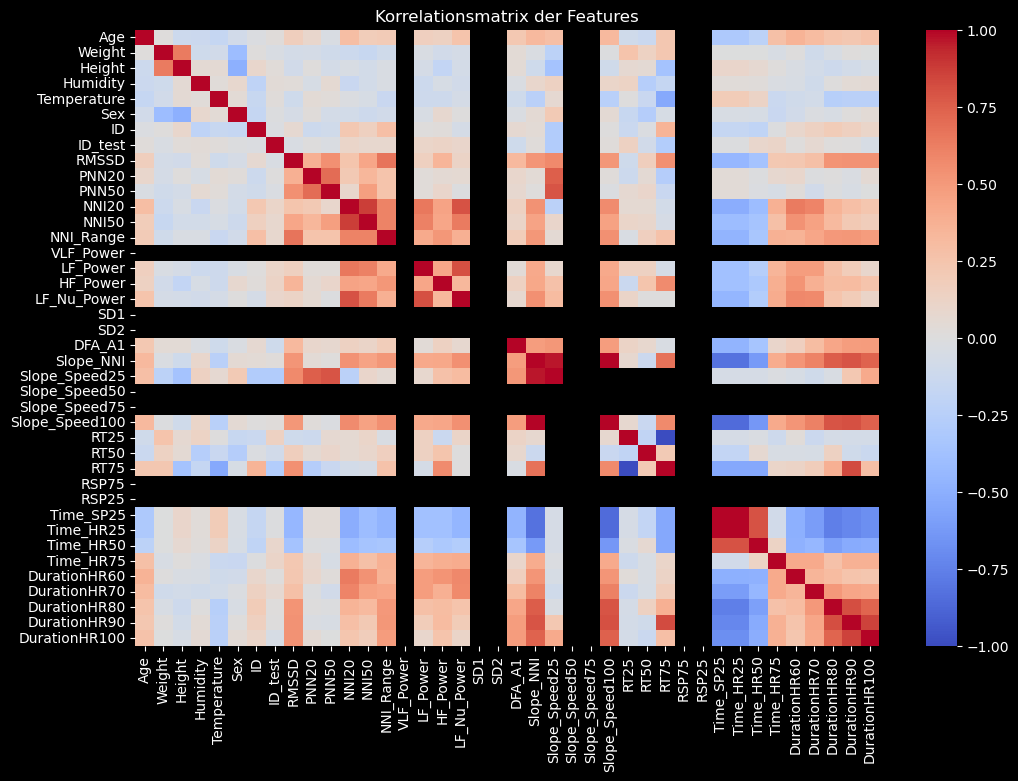


Stark korrelierte Feature-Paare:
          PNN20         PNN50     NNI20                 NNI50    LF_Power  \
  Slope_Speed25 Slope_Speed25     NNI50 LF_Nu_Power     NNI20 LF_Nu_Power   
0      0.756541      0.792772  0.869707    0.803358  0.869707     0.80598   

  LF_Nu_Power              Slope_NNI                 ...   DurationHR90  \
        NNI20 LF_Power Slope_Speed25 Slope_Speed100  ... Slope_Speed100   
0    0.803358  0.80598      0.963967       0.999092  ...       0.805979   

                                                           DurationHR100  \
       RT75 Time_SP25 Time_HR25 DurationHR80 DurationHR100     Slope_NNI   
0  0.823447 -0.722457 -0.722457     0.819655      0.851614      0.742091   

                                            
  Slope_Speed100 DurationHR80 DurationHR90  
0       0.745605     0.729549     0.851614  

[1 rows x 58 columns]


In [43]:
def correlated_features(dataframe, threshold=0.7):
    # Berechne die Korrelationsmatrix
    correlation_matrix = dataframe.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
    plt.title('Korrelationsmatrix der Features')
    plt.show()
    # Finde stark korrelierte Feature-Paare
    highly_correlated_pairs = correlation_matrix.where((correlation_matrix.abs() > threshold) & (np.eye(correlation_matrix.shape[0]) == 0)).stack()
    highly_correlated_pairs = pd.DataFrame(highly_correlated_pairs).T
    
    if not highly_correlated_pairs.empty:
        print("\nStark korrelierte Feature-Paare:")
        print(highly_correlated_pairs)

    return highly_correlated_pairs

highly_correlated_pairs_exercise = correlated_features(normalized_features_exercise, threshold=0.7)
highly_correlated_pairs_recovery = correlated_features(normalized_features_recovery, threshold=0.7)

# 3. Korrelation mit dem Zielwert
#correlation_with_target = normalized_features.corr()[target_column].drop(target_column)

# Features mit starker Korrelation zum Zielwert
#strongly_correlated_features = correlation_with_target[correlation_with_target.abs() > 0.5]
#print("Features mit starker Korrelation zum Zielwert:")
#print(strongly_correlated_features)

# 5. Mutual Information für nicht-lineare Zusammenhänge
#mi_scores = mutual_info_regression(features, target)
#mi_scores_df = pd.Series(mi_scores, index=features.columns).sort_values(ascending=False)
#print("\nMutual Information Scores:")
#print(mi_scores_df)

# 6. Scatterplots für interessante Features
#top_features = mi_scores_df.head(5).index  # Die 5 wichtigsten Features
#for feature in top_features:
 #   plt.figure(figsize=(6, 4))
  #  sns.scatterplot(x=features[feature], y=target)
   # plt.title(f"Zusammenhang zwischen {feature} und Zielwert")
    #plt.xlabel(feature)
    #plt.ylabel(target_column)
    #plt.show()


In [44]:
from collections import Counter
def remove_correlated_features(dataframe, highly_correlated_pairs):
    # Flatten pairs to count occurrences of each feature
    flat_features = [item for pair in highly_correlated_pairs for item in pair]
    feature_counts = Counter(flat_features)

    # Initialize sets to keep track of features to keep and drop
    features_to_keep = set()
    features_to_drop = set()

    # Process each pair to decide which feature to drop
    for feature1, feature2 in highly_correlated_pairs:
        # If neither feature is already marked for keeping, drop the less frequent one
        if feature1 not in features_to_keep and feature2 not in features_to_keep:
            if feature_counts[feature1] >= feature_counts[feature2]:
                features_to_keep.add(feature1)
                features_to_drop.add(feature2)
            else:
                features_to_keep.add(feature2)
                features_to_drop.add(feature1)
        # If one is already kept, drop the other
        elif feature1 in features_to_keep:
            features_to_drop.add(feature2)
        elif feature2 in features_to_keep:
            features_to_drop.add(feature1)

    # Get the final list of features to keep
    final_features = set(flat_features) - features_to_drop
    print(f"Features to keep: {sorted(final_features)}")
    print(f"Features to drop: {sorted(features_to_drop)}")
    reduced_data = dataframe.drop(columns=features_to_drop)
    return reduced_data


reduced_exercise_data = remove_correlated_features(normalized_features_exercise, highly_correlated_pairs_exercise)
reduced_recovery_data = remove_correlated_features(normalized_features_recovery, highly_correlated_pairs_recovery)

Features to keep: ['NNI20', 'PNN50', 'Slope_Speed25', 'Time_SP25']
Features to drop: ['NNI50', 'PNN20', 'RMSSD', 'RT25', 'Time_HR25', 'Time_HR50']
Features to keep: ['Slope_Speed25']
Features to drop: ['DurationHR100', 'DurationHR80', 'DurationHR90', 'LF_Nu_Power', 'LF_Power', 'NNI20', 'NNI50', 'PNN20', 'PNN50', 'RT25', 'RT75', 'Slope_NNI', 'Slope_Speed100', 'Time_HR25', 'Time_HR50', 'Time_SP25']
